In [13]:
import zarr
import numpy as np

# === Your Zarr ===
DIR = '/mnt/efs/aimbl_2025/student_data/S-LS/marker_data.zarr'
z_data = zarr.open(DIR, mode='r')

# === Datasets (as you named them) ===
masks  = z_data['pred_mask_bacteria']['pred_mask_stack'][:1]   # (N,H,W), int labels (0=bg, 1..K)
marker = z_data['marker']['marker_stack'][:1]                  # (N,H,W), uint16 intensities
raw    = z_data['bacteria']['raw_bacteria_stack'][:1]         # (N,H,W), raw image for context

N, H, W = raw.shape
print("shape:", (N, H, W), masks.dtype, marker.dtype, raw.dtype)

shape: (1, 2208, 2752) uint16 uint16 uint16


In [14]:
def band_intensity_stats(band_labels: np.ndarray, marker2d: np.ndarray):
    """
    (Optional) Mean/Max intensity per label on the band (not thresholded).
    Useful for exploring intensity distributions before picking a threshold.
    """
    if band_labels.max() == 0:
        return {}, {}, {}, {}
    props = regionprops_table(
        band_labels, intensity_image=marker2d.astype(np.float32),
        properties=("label", "mean_intensity", "max_intensity", "area", "bbox", "centroid")
    )
    mean_by = {int(l): float(m) for l, m in zip(props["label"], props["mean_intensity"])}
    max_by  = {int(l): float(m) for l, m in zip(props["label"], props["max_intensity"])}
    area_by = {int(l): int(a)   for l, a in zip(props["label"], props["area"])}
    bbox_by = {
        int(l): (int(r0), int(c0), int(r1), int(c1))
        for l, r0, c0, r1, c1 in zip(
            props["label"], props["bbox-0"], props["bbox-1"], props["bbox-2"], props["bbox-3"]
        )
    }
    return mean_by, max_by, area_by, bbox_by

In [15]:
from skimage.segmentation import expand_labels, find_boundaries
from skimage.morphology import erosion, disk
from skimage.measure import regionprops_table
import matplotlib.pyplot as plt

def band_two_sided(labels2d: np.ndarray, r_out: int = 2, r_in: int = 1) -> np.ndarray:
    """
    Two-sided label-preserving band around each object:
      - Outer band = expand_labels(labels, r_out) minus original labels
      - Inner band = original labels minus per-object erosion by disk(r_in)
    Returns band_labels: same ids as labels on band pixels, 0 elsewhere.
    """
    labels2d = labels2d.astype(np.int32, copy=False)

    # Outer band (keeps instances separate)
    r_out = int(max(0, r_out))
    expanded = expand_labels(labels2d, distance=r_out) if r_out > 0 else labels2d
    outer = expanded.copy()
    outer[labels2d != 0] = 0  # only the newly added outside ring

    # Inner band (per-object erosion to get a thin inner ring)
    r_in = int(max(0, r_in))
    if r_in > 0:
        se = disk(r_in)
        inner = np.zeros_like(labels2d, dtype=np.int32)
        for oid in np.unique(labels2d):
            if oid == 0:
                continue
            obj = (labels2d == oid)
            er = erosion(obj, se)                 # shrink object inward
            inner_ring = obj & (~er)              # original minus eroded = inner band
            inner[inner_ring] = oid
    else:
        inner = np.zeros_like(labels2d, dtype=np.int32)

    band = inner.copy()
    band[outer != 0] = outer[outer != 0]          # union of inner+outer bands
    return band

In [16]:
def band_coverage_per_label(band_labels: np.ndarray, marker2d: np.ndarray, thr: int, return_area=False):
    """
    Coverage fraction per label on the band:
      coverage[label] = (# band pixels with marker >= thr) / (band area)
    marker2d is uint16; thr should be uint16-ish (e.g., 1200).
    """
    if band_labels.max() == 0:
        return ({}, {}) if return_area else {}

    pos = (marker2d >= thr).astype(np.uint8)  # boolean -> 0/1 so mean = fraction
    props = regionprops_table(
        band_labels, intensity_image=pos,
        properties=("label", "mean_intensity", "area")
    )
    coverage = {int(l): float(m) for l, m in zip(props["label"], props["mean_intensity"])} #mean intensity divides it across the area
    if return_area:
        area = {int(l): int(a) for l, a in zip(props["label"], props["area"])}
        return coverage, area
    return coverage

In [17]:
R_OUT = 2   # outer pixels
R_IN  = 1   # inner pixels

index = []  # list of dicts: {img_i, label, mean, max, bbox}

#for i in range(N):
for i in range(1):
    lbl = masks[i]
    if lbl.max() == 0:
        continue
    band = band_two_sided(lbl, r_out=R_OUT, r_in=R_IN)
    mean_by, max_by, area_by, bbox_by = band_intensity_stats(band, marker[i])

    for oid, bbox in bbox_by.items():
        index.append({
            "img_i": i,
            "label": int(oid),
            "mean": float(mean_by.get(oid, 0.0)),
            "max":  float(max_by.get(oid, 0.0)),
            "bbox": bbox
        })
    print("Finished image", i)

# print(f"Indexed {len(index)} instances across {N} images (r_out={R_OUT}, r_in={R_IN}).")
print(f"Indexed {len(index)} instances across 3 images (r_out={R_OUT}, r_in={R_IN}).")

Finished image 0
Indexed 136 instances across 3 images (r_out=2, r_in=1).


In [18]:
# Build once (after you construct `index`)
IMG_IDS = sorted({item["img_i"] for item in index})

# Caches
BAND_CACHE = {}          # key: (R_OUT, R_IN, img_i) -> band_labels (H,W)
COVERAGE_CACHE = {}      # key: (THR, R_OUT, R_IN) -> {img_i: {label_id: coverage}}

In [19]:
def get_band_for_image(img_i, r_out, r_in):
    key = (r_out, r_in, img_i)
    band = BAND_CACHE.get(key)
    if band is None:
        band = band_two_sided(masks[img_i], r_out=r_out, r_in=r_in)
        BAND_CACHE[key] = band
    return band

def get_coverage_map(thr, r_out, r_in):
    """
    Returns a dict: img_i -> {label_id: coverage} for the given threshold
    using cached bands. Computes once per image per (thr, r_out, r_in).
    """
    key = (thr, r_out, r_in)
    cov_map = COVERAGE_CACHE.get(key)
    if cov_map is not None:
        return cov_map

    cov_map = {}
    for i in IMG_IDS:
        band = get_band_for_image(i, r_out, r_in)
        cov_map[i] = band_coverage_per_label(band, marker[i], thr=thr)
    COVERAGE_CACHE[key] = cov_map

In [20]:
def crop_with_margin(y0, x0, y1, x1, margin, H, W):
    y0 = max(0, y0 - margin); x0 = max(0, x0 - margin)
    y1 = min(H, y1 + margin); x1 = min(W, x1 + margin)
    return y0, x0, y1, x1

def rescale_for_display(arr, p_lo=1, p_hi=99.5):
    """Percentile-based rescale to [0,1] for prettier plots (doesn't affect analysis)."""
    a = arr.astype(np.float32)
    lo, hi = np.percentile(a, [p_lo, p_hi])
    if hi <= lo:
        return np.clip((a - lo), 0, 1)
    a = (a - lo) / (hi - lo)
    return np.clip(a, 0, 1)

In [9]:
def show_examples_coverage(
    index,
    thr: int,
    coverage_min=0.5,
    n=12,
    mode="positive",          # 'positive', 'negative', 'near'
    margin=6,
    seed=0,
    thr_relax: int | None = None,
    relax_factor: float = 0.8  # used only if thr_relax is None
):
    """
    Visualize examples by coverage at a given intensity threshold (uint16).

    Semantics:
      - positive: coverage(thr) >= coverage_min
      - negative: coverage(thr) < coverage_min AND coverage(thr_relax) >= coverage_min
                  (i.e., would be positive if threshold were relaxed)
      - near:     |coverage(thr) - coverage_min| <= 10% of coverage_min
    """
    rng = np.random.default_rng(seed)

    # Decide the relaxed threshold to test "what-if" cases for negative mode
    if thr_relax is None:
        thr_relax = max(0, int(thr * relax_factor))

    # 1) Get per-image coverage maps from cache (fast)
    cov_by_img_hi = get_coverage_map(thr,      R_OUT, R_IN)
    cov_by_img_lo = get_coverage_map(thr_relax, R_OUT, R_IN)

    # 2) Build per-instance coverage arrays (aligned with `index`)
    cov_hi = np.array([cov_by_img_hi[item["img_i"]].get(item["label"], 0.0) for item in index], dtype=float)
    cov_lo = np.array([cov_by_img_lo[item["img_i"]].get(item["label"], 0.0) for item in index], dtype=float)

    # 3) Select indices by mode
    if mode == "positive":
        sel = np.where(cov_hi >= coverage_min)[0]

    elif mode == "negative":
        # Below current cutoff, but would pass if we relaxed intensity threshold
        sel = np.where((cov_hi < coverage_min) & (cov_lo >= coverage_min))[0]

    elif mode == "near":
        band = 0.1 * coverage_min  # ±10% band around the cutoff
        lo, hi = coverage_min - band, coverage_min + band
        sel = np.where((cov_hi >= lo) & (cov_hi <= hi))[0]

    else:
        raise ValueError("mode must be 'positive', 'negative', or 'near'")

    if sel.size == 0:
        print("No examples match this filter.")
        return

    rng.shuffle(sel)
    sel = sel[:n]

    # 4) Plot
    rows = len(sel); cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(6, 2.5*rows))
    if rows == 1:
        axes = np.array([axes])

    for r, k in enumerate(sel):
        item = index[int(k)]
        i, oid = item["img_i"], item["label"]
        y0, x0, y1, x1 = crop_with_margin(*item["bbox"], margin, H, W)

        img_raw = rescale_for_display(raw[i][y0:y1, x0:x1])
        img_mrk = rescale_for_display(marker[i][y0:y1, x0:x1].astype(np.float32))

        # Cached band for overlay
        full_band = get_band_for_image(i, R_OUT, R_IN)
        band_crop = (full_band[y0:y1, x0:x1] == oid)

        lbl_crop = (masks[i][y0:y1, x0:x1] == oid)
        bnd_crop = find_boundaries(lbl_crop, mode="outer")

        # Coverage numbers for annotation
        cov_val_hi = cov_by_img_hi[i].get(oid, 0.0)
        cov_val_lo = cov_by_img_lo[i].get(oid, 0.0)

        axL = axes[r, 0]
        axL.imshow(img_raw, cmap="gray")
        axL.contour(bnd_crop, levels=[0.5], linewidths=1.0)
        axL.set_title(f"img {i}, id {oid}\ncoverage@{thr}={cov_val_hi:.2f}")
        axL.axis("off")

        axR = axes[r, 1]
        axR.imshow(img_mrk, cmap="gray")
        axR.contour(band_crop, levels=[0.5], linewidths=1.0)
        axR.set_title(f"marker ≥ {thr} (uint16)\nrelax→{thr_relax}, cov@relax={cov_val_lo:.2f}")
        axR.axis("off")

    title = f"Examples ({mode}) — cov_min={coverage_min}, thr={thr}, thr_relax={thr_relax} (uint16)"
    fig.suptitle(title, y=0.995)
    plt.tight_layout()
    plt.show()

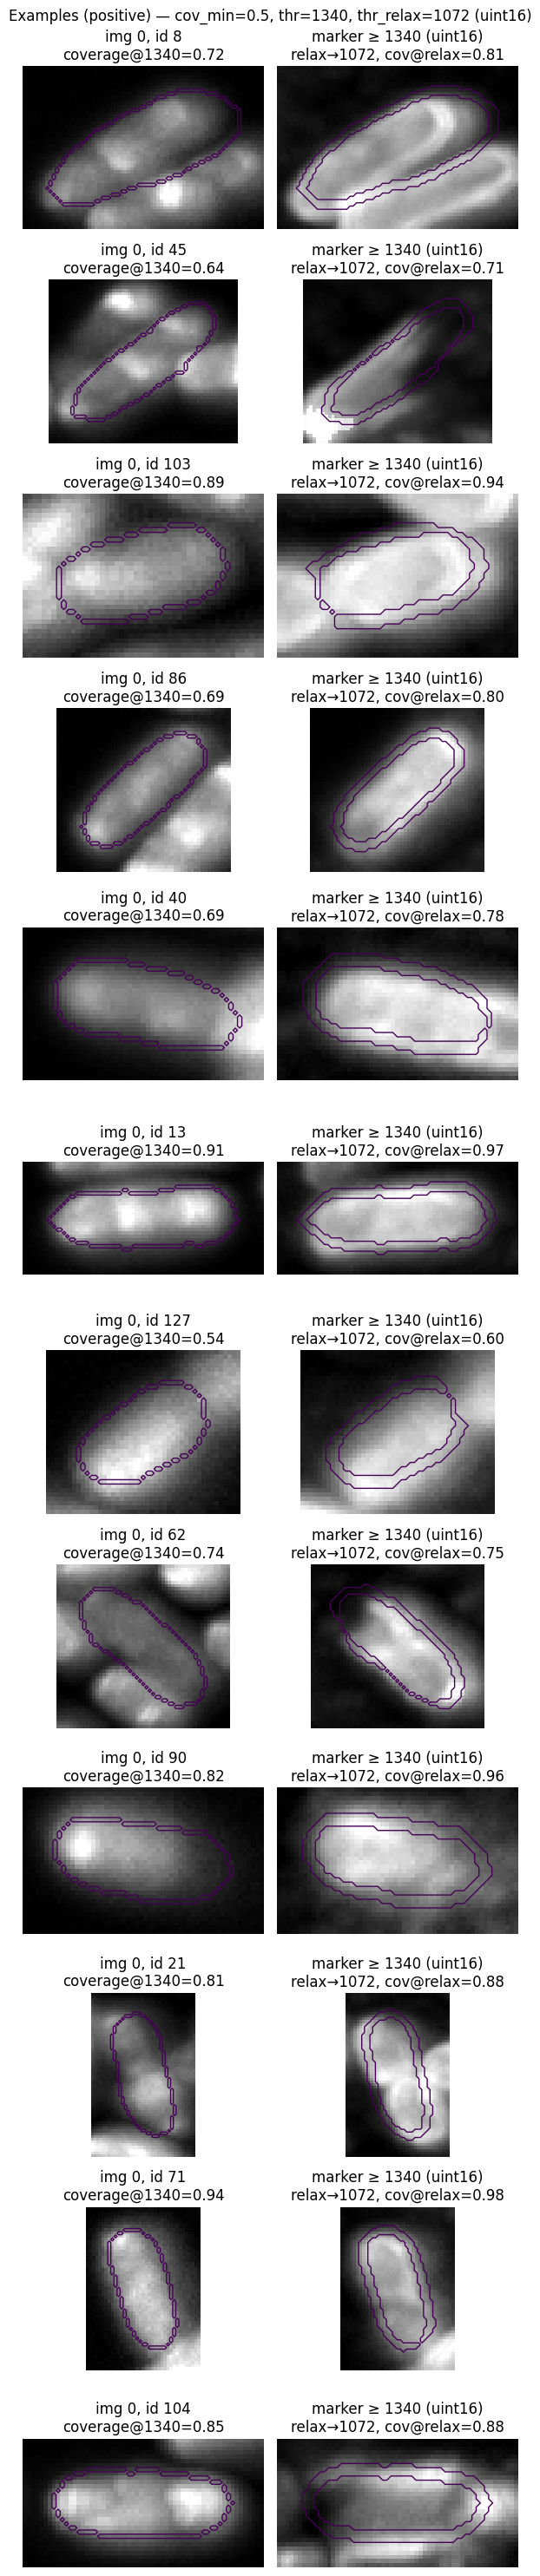

In [12]:
show_examples_coverage(
    index,
    thr= 1340,
    coverage_min=0.5,
    n=12,
    mode='positive',          # 'positive', 'negative', 'near'
    margin=6,
    seed=0,
    thr_relax=None,
    relax_factor= 0.8  # used only if thr_relax is None
)

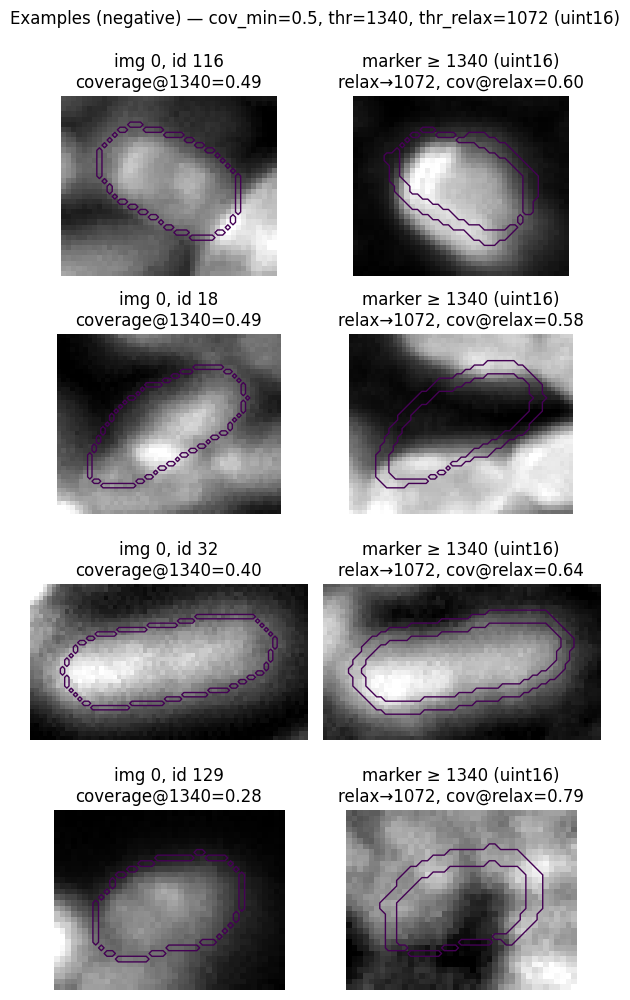

In [13]:
show_examples_coverage(
    index,
    thr= 1340,
    coverage_min=0.5,
    n=12,
    mode='negative',          # 'positive', 'negative', 'near'
    margin=6,
    seed=0,
    thr_relax=None,
    relax_factor= 0.8)  # used only if thr_relax is None

In [21]:
def show_examples_coverage(index, thr: int, coverage_min=0.5, n=12,
                           mode="positive", margin=6, seed=0):
    """
    mode: 'positive' (coverage>=min), 'negative' (<min), 'near' (within ±10% of min)
    Uses cached bands and per-image coverage maps ⇒ much faster.
    """
    rng = np.random.default_rng(seed)

    # 1) Get coverage per instance quickly via the cache
    cov_by_img = get_coverage_map(thr, R_OUT, R_IN)
    cov_vals = np.array(
        [cov_by_img[item["img_i"]].get(item["label"], 0.0) for item in index],
        dtype=float
    )

    # 2) Select indices by mode
    if mode == "positive":
        sel = np.where(cov_vals >= coverage_min)[0]
    elif mode == "negative":
        sel = np.where(cov_vals < coverage_min)[0]
    elif mode == "near":
        lo, hi = 0.9*coverage_min, 1.1*coverage_min
        sel = np.where((cov_vals >= lo) & (cov_vals <= hi))[0]
    else:
        raise ValueError("mode must be 'positive', 'negative', or 'near'")

    if sel.size == 0:
        print("No examples match this filter.")
        return

    rng.shuffle(sel)
    sel = sel[:n]

    # 3) Plot
    rows = len(sel); cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(6, 2.5*rows))
    if rows == 1:
        axes = np.array([axes])

    for r, k in enumerate(sel):
        item = index[int(k)]
        i, oid = item["img_i"], item["label"]
        y0, x0, y1, x1 = crop_with_margin(*item["bbox"], margin, H, W)

        img_raw = rescale_for_display(raw[i][y0:y1, x0:x1])
        img_mrk = rescale_for_display(marker[i][y0:y1, x0:x1].astype(np.float32))

        # Use cached band & coverage
        full_band = get_band_for_image(i, R_OUT, R_IN)
        band_crop = (full_band[y0:y1, x0:x1] == oid)

        lbl_crop = (masks[i][y0:y1, x0:x1] == oid)
        bnd_crop = find_boundaries(lbl_crop, mode="outer")

        cov = cov_by_img[i].get(oid, 0.0)

        axL = axes[r, 0]
        axL.imshow(img_raw, cmap="gray")
        axL.contour(bnd_crop, levels=[0.5], linewidths=1.0)
        axL.set_title(f"img {i}, id {oid}\ncoverage={cov:.2f}")
        axL.axis("off")

        axR = axes[r, 1]
        axR.imshow(img_mrk, cmap="gray")
        axR.contour(band_crop, levels=[0.5], linewidths=1.0)
        axR.set_title(f"marker ≥ {thr} (uint16)\nband r_out={R_OUT}, r_in={R_IN}")
        axR.axis("off")

    fig.suptitle(f"Examples ({mode}) — coverage≥{coverage_min}", y=0.995)
    plt.tight_layout()
    plt.show()

In [21]:
from skimage.filters import threshold_otsu

# Collect all band pixels across the dataset to suggest a global threshold
all_band_vals = []
# for i in range(N):
for i in range(1):
    band = band_two_sided(masks[i], r_out=R_OUT, r_in=R_IN)
    vals = marker[i][band != 0]
    if vals.size:
        all_band_vals.append(vals.astype(np.uint16))
all_band_vals = np.concatenate(all_band_vals) if all_band_vals else np.array([], dtype=np.uint16)

if all_band_vals.size:
    otsu_thr = int(threshold_otsu(all_band_vals))
    p10, p50, p90 = np.percentile(all_band_vals, [10, 50, 90])
    print(f"Global Otsu (band pixels): {otsu_thr} | band percentiles: p10={p10:.0f}, p50={p50:.0f}, p90={p90:.0f}")
else:
    print("No band pixels found for Otsu.")

Global Otsu (band pixels): 1809 | band percentiles: p10=228, p50=581, p90=2726



=== THRESHOLD CANDIDATE: 228.0 (uint16) ===


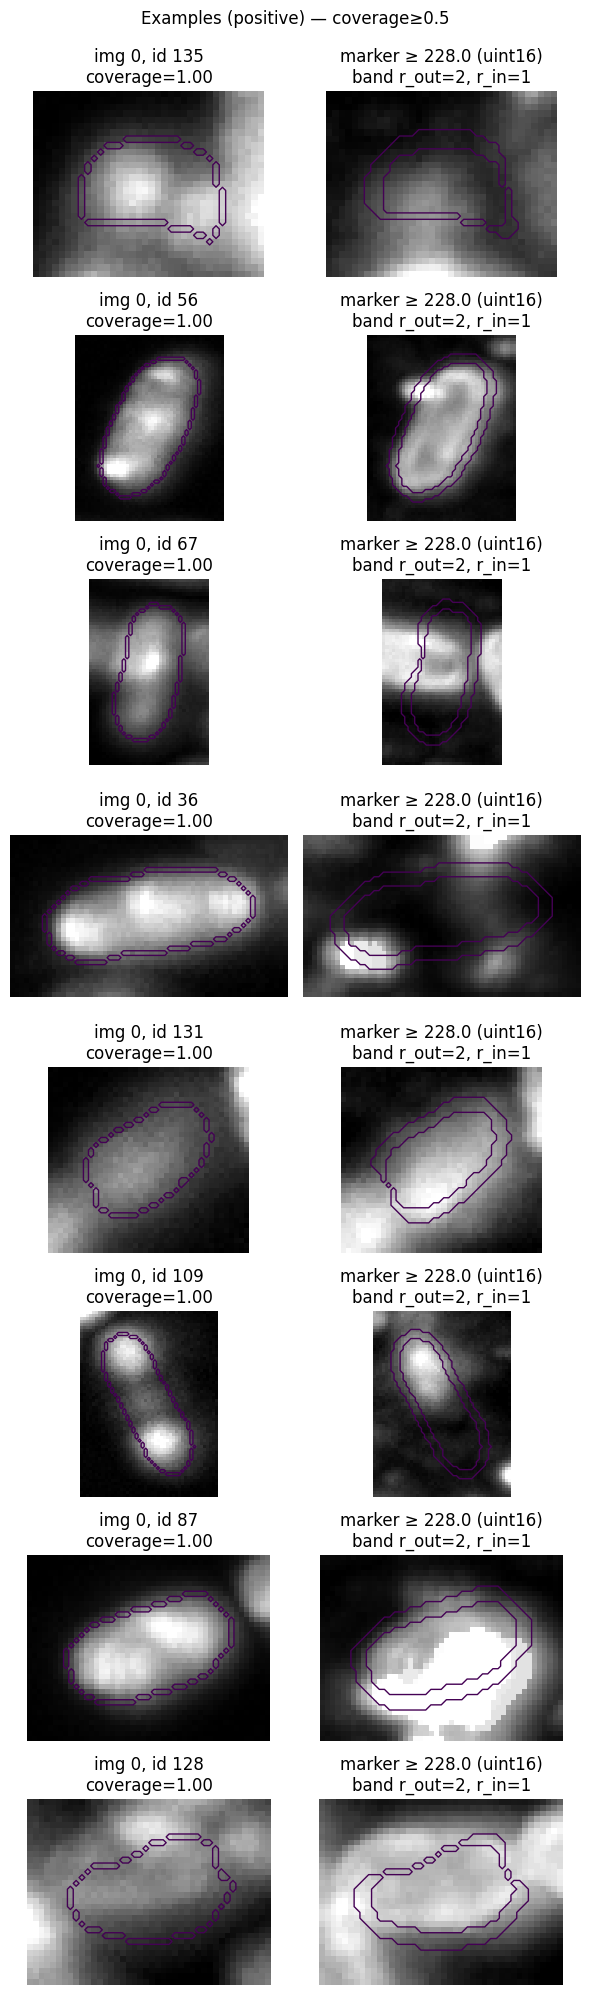

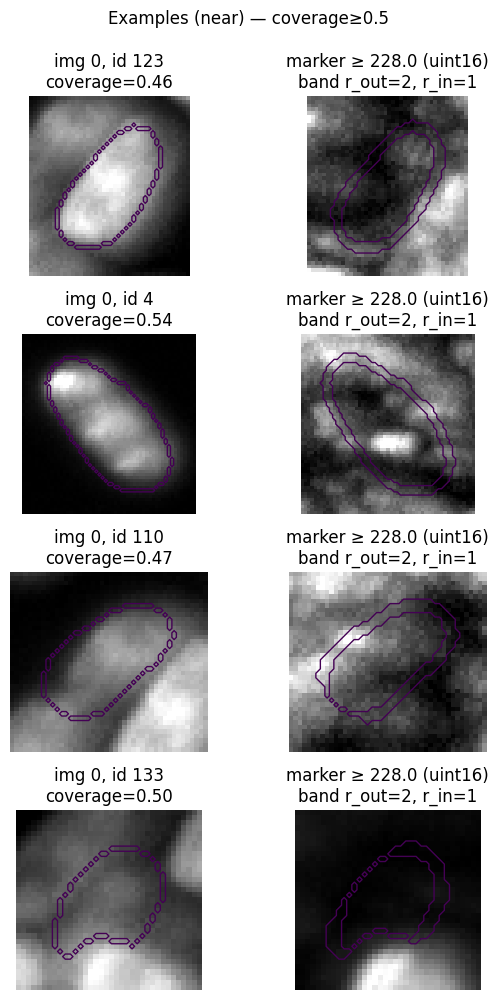

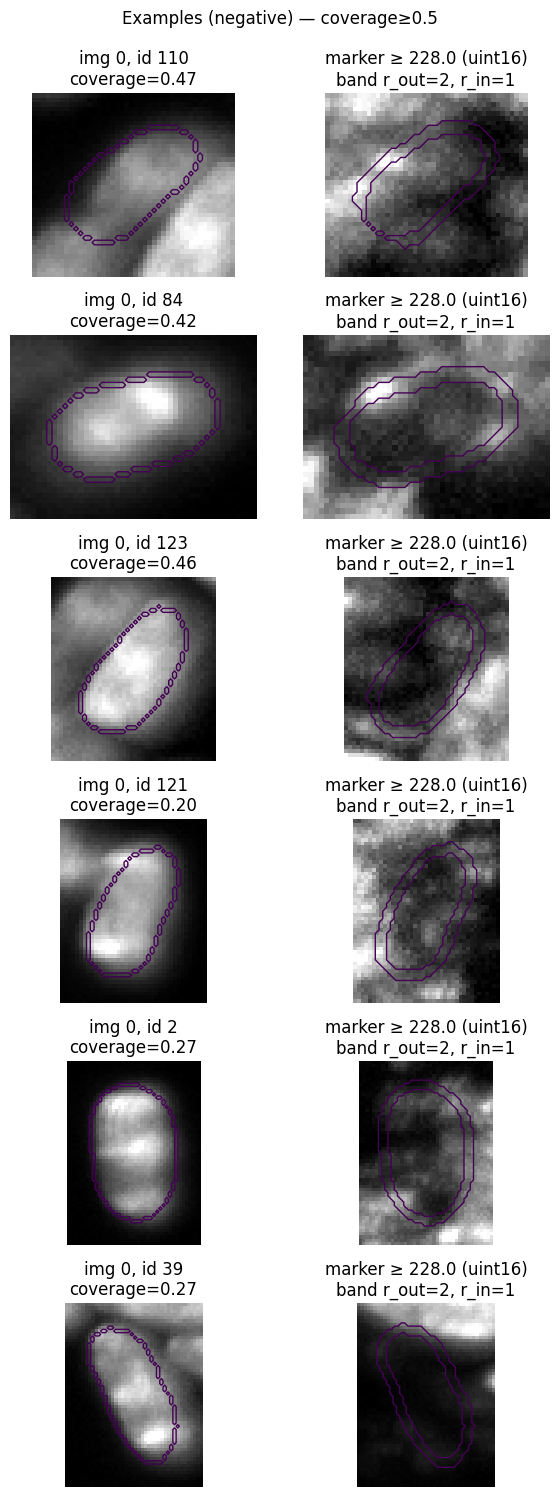


=== THRESHOLD CANDIDATE: 581.0 (uint16) ===


TypeError: 'NoneType' object is not subscriptable

In [25]:
# Try a few candidates around Otsu and the med/high you eyeballed
# thr_candidates = [int(0.8*otsu_thr), otsu_thr, int(1.2*otsu_thr)]
thr_candidates = [p10, p50, p90]
# You can also add a percentile-based candidate if useful, e.g., int(p75) or int(p90)

for thr in thr_candidates:
    print(f"\n=== THRESHOLD CANDIDATE: {thr} (uint16) ===")
    # Clearly positive examples
    show_examples_coverage(index, thr=thr, coverage_min=0.5, n=8, mode="positive", margin=6, seed=0)
    # Borderline ones—these decide your final choice
    show_examples_coverage(index, thr=thr, coverage_min=0.5, n=8, mode="near",     margin=6, seed=0)
    # Negatives—sanity check you’re not missing obvious trues
    show_examples_coverage(index, thr=thr, coverage_min=0.5, n=8, mode="negative", margin=6, seed=0)

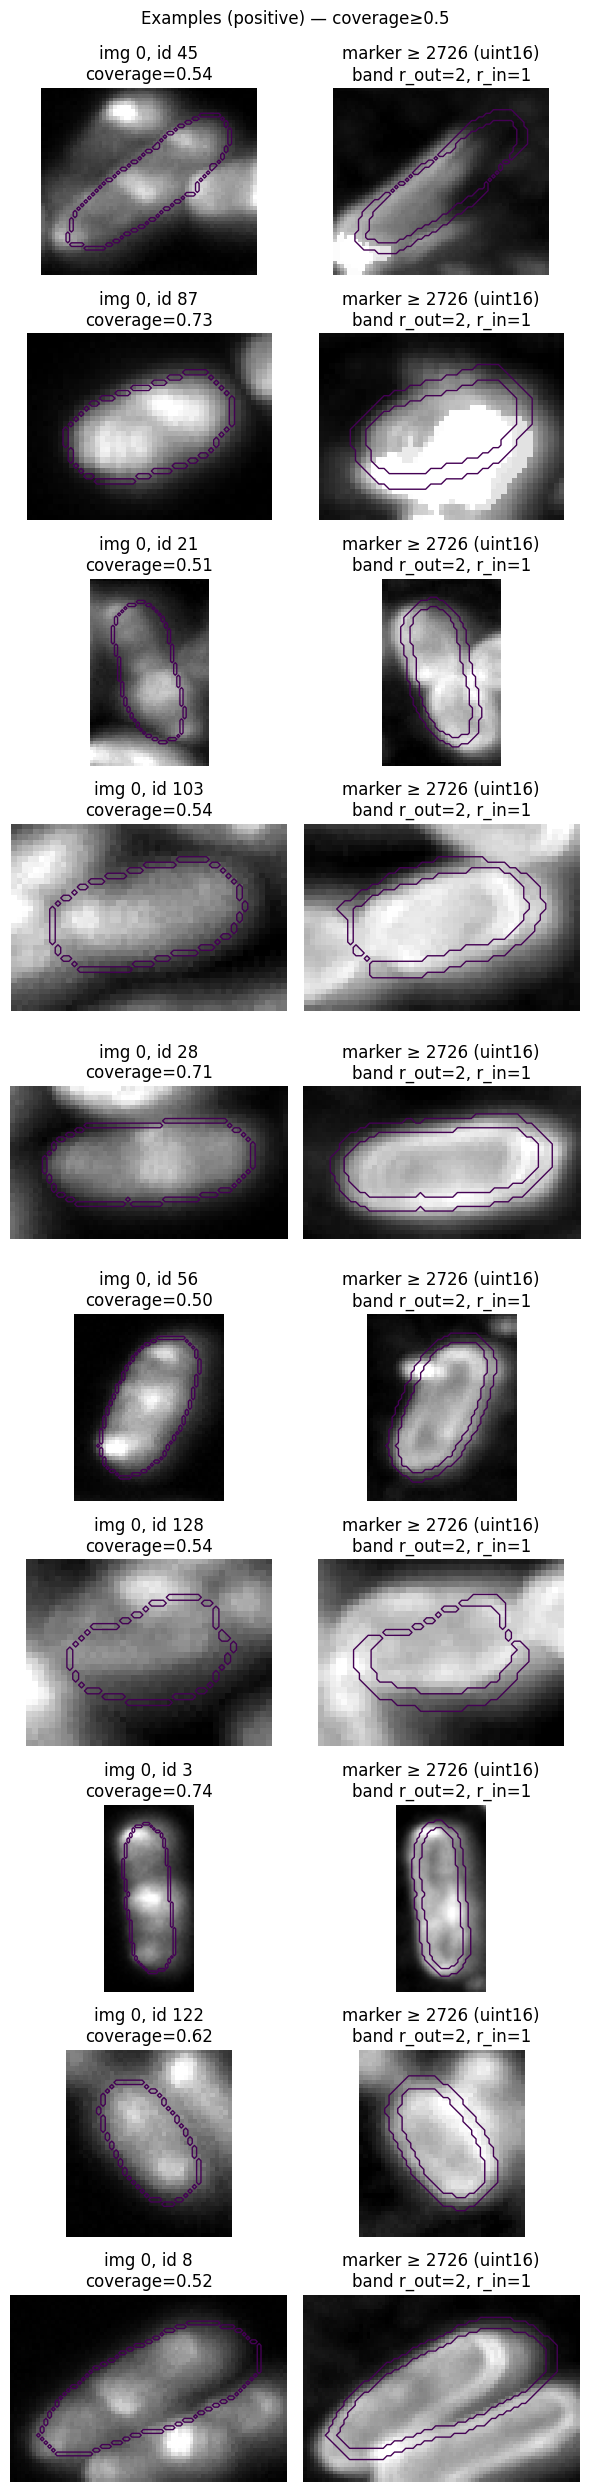

In [27]:
# === Pick a candidate threshold in uint16, then preview ===
THR_CANDIDATE = 2726   # <-- choose based on browsing / Otsu / biology
show_examples_coverage(index, thr=THR_CANDIDATE, coverage_min=0.5, n=12, mode="positive", margin=6, seed=0)

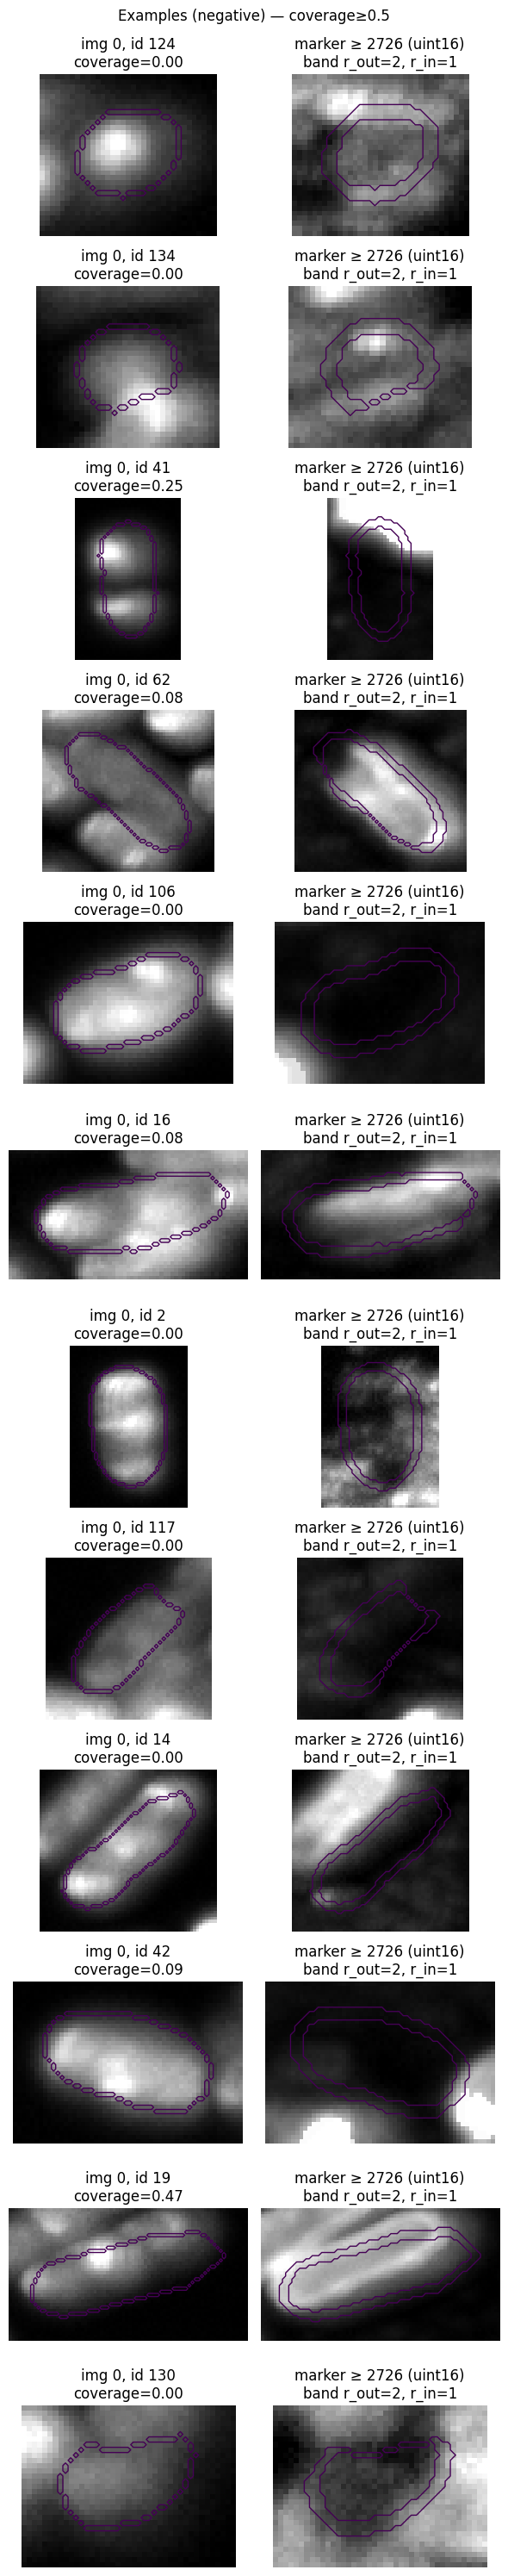

In [28]:
# === Pick a candidate threshold in uint16, then preview ===
THR_CANDIDATE = 2726   # <-- choose based on browsing / Otsu / biology
show_examples_coverage(index, thr=THR_CANDIDATE, coverage_min=0.5, n=12, mode="negative", margin=6, seed=0)

In [23]:
BAND_CACHE.clear()
COVERAGE_CACHE.clear()

In [24]:
# === Pick a candidate threshold in uint16, then preview ===
THR_CANDIDATE = 2800   # <-- choose based on browsing / Otsu / biology
show_examples_coverage(index, thr=THR_CANDIDATE, coverage_min=0.5, n=12, mode="positive", margin=6, seed=2)

TypeError: 'NoneType' object is not subscriptable

In [25]:
# Make sure these exist exactly once
try:
    BAND_CACHE
except NameError:
    BAND_CACHE = {}

try:
    COVERAGE_CACHE
except NameError:
    COVERAGE_CACHE = {}

def get_band_for_image(img_i, r_out, r_in):
    key = (int(r_out), int(r_in), int(img_i))
    band = BAND_CACHE.get(key)
    if band is None:
        band = band_two_sided(masks[int(img_i)], r_out=int(r_out), r_in=int(r_in))
        BAND_CACHE[key] = band
    return band

In [26]:
def get_coverage_map(thr, r_out, r_in):
    """
    Returns: dict {img_i: {label_id: coverage_float}}
    Builds per image once, caches by (thr, r_out, r_in).
    """
    key = (int(thr), int(r_out), int(r_in))
    cov_map = COVERAGE_CACHE.get(key, None)

    # If already computed and valid, reuse it
    if isinstance(cov_map, dict):
        return cov_map

    # (Re)compute for ALL images 0..N-1; safe even if some have no objects
    cov_map = {}
    for i in range(N):
        band = get_band_for_image(i, r_out, r_in)
        cov_map[i] = band_coverage_per_label(band, marker[i], thr=int(thr))
    COVERAGE_CACHE[key] = cov_map
    return cov_map

In [31]:
import numpy as np

def count_positives(thr, coverage_min):
    cov_by_img = get_coverage_map(thr, R_OUT, R_IN)
    # sanity guard
    if not isinstance(cov_by_img, dict):
        raise RuntimeError("get_coverage_map did not return a dict")

    total_pos = 0
    total_inst = 0
    for i in range(N):
        ids = np.unique(masks[i]); ids = ids[ids != 0]
        cov_i = cov_by_img.get(i, {})  # may be empty dict if no band/objects
        total_pos += sum(1 for oid in ids if cov_i.get(int(oid), 0.0) >= coverage_min)
        total_inst += len(ids)
    return total_pos, total_inst

thr_list = [800, 1200, 1340, 1600, 1809, 2000, 2400]          # pick around your data’s range
cov_list = [0.3, 0.5, 0.7]                         # try a few coverage cutoffs

for cov_min in cov_list:
    print(f"\ncoverage_min = {cov_min}")
    for thr in thr_list:
        pos, inst = count_positives(thr, cov_min)
        pct = 100 * pos / max(inst, 1)
        print(f"  thr={thr:4d} → positives {pos}/{inst}  ({pct:.1f}%)")


coverage_min = 0.3
  thr= 800 → positives 67/136  (49.3%)
  thr=1200 → positives 45/136  (33.1%)
  thr=1340 → positives 40/136  (29.4%)
  thr=1600 → positives 36/136  (26.5%)
  thr=1809 → positives 35/136  (25.7%)
  thr=2000 → positives 31/136  (22.8%)
  thr=2400 → positives 25/136  (18.4%)

coverage_min = 0.5
  thr= 800 → positives 46/136  (33.8%)
  thr=1200 → positives 36/136  (26.5%)
  thr=1340 → positives 32/136  (23.5%)
  thr=1600 → positives 27/136  (19.9%)
  thr=1809 → positives 25/136  (18.4%)
  thr=2000 → positives 21/136  (15.4%)
  thr=2400 → positives 14/136  (10.3%)

coverage_min = 0.7
  thr= 800 → positives 36/136  (26.5%)
  thr=1200 → positives 26/136  (19.1%)
  thr=1340 → positives 22/136  (16.2%)
  thr=1600 → positives 15/136  (11.0%)
  thr=1809 → positives 11/136  (8.1%)
  thr=2000 → positives 8/136  (5.9%)
  thr=2400 → positives 4/136  (2.9%)
